# navie word2vec demo 
先对小规模文本做一个demo便于调试

主要设计简单的cbow和skipgram

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import random
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
## text摘自pytorch 官网
text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".replace(".","").split()

vocab=set(text)
vocab_count=Counter(text)
w2i = {v:i for i,v in enumerate(vocab)}
i2w = {i:v for i,v in enumerate(vocab)}
print("len of vocab:{}".format(len(vocab)))
# print("count of word 'processes'：{}".format(vocab_count["a"]))

len of vocab:47


## 简易的dataset

In [3]:
def create_cbow_dataset(text):
    directions=[v for v in range(1,CONTEXT_SIZE+1)]+[-v for v in range(1,CONTEXT_SIZE+1)]
    data=[]
    for i in range(2,(len(text))-2):
        context=[]
        for direct in directions:
            new_i = i+direct
            if 0<=new_i<len(text):
                context.append(text[new_i])
        target=text[i]
        data.append((context,target))
    return data

def create_skipgram_dataset(text):
    directions=[v for v in range(1,CONTEXT_SIZE+1)]+[-v for v in range(1,CONTEXT_SIZE+1)]
    data=[]
    for i in range(2,(len(text))-2):
        target=[]
        for direct in directions:
            new_i = i+direct
            if 0<=new_i<len(text):
                target.append(text[new_i])
        context=text[i]
        data.append((context,target))
    return data

cbow_train_data = create_cbow_dataset(text)
skipgram_train_data = create_skipgram_dataset(text)
print('cbow sample', cbow_train_data[2])
print('cbow sample', cbow_train_data[0])
print('skipgram sample', skipgram_train_data[2])
print('skipgram sample', skipgram_train_data[20])
print('skipgram sample', skipgram_train_data[0])
# print(skipgram_train_data)

cbow sample (['the', 'idea', 'to', 'about'], 'study')
cbow sample (['to', 'study', 'are', 'We'], 'about')
skipgram sample ('study', ['the', 'idea', 'to', 'about'])
skipgram sample ('processes', ['manipulate', 'other', 'evolve,', 'they'])
skipgram sample ('about', ['to', 'study', 'are', 'We'])


## CBOW模型

In [4]:
class CBOW(nn.Module):
    def __init__(self,vocab_size,embd_size,hid_size,context_size):
        super(CBOW,self).__init__()
        self.emb=nn.Embedding(vocab_size,embd_size)
        self.layer=nn.Sequential(
            nn.Linear(2*context_size*embd_size,hid_size),
            nn.Tanh(),
            nn.Linear(hid_size,vocab_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self,inputs):
        emb_out=self.emb(inputs).view((1,-1))
        log_prob=self.layer(emb_out)
        return log_prob  


## CBOW 训练

In [5]:
embd_size = 100
learning_rate = 3e-3
# CONTEXT_SIZE = 2 之前定义的
hidden_size=64
dim_embedding=100

def cbow_train(n_epoch):
    loss_fn = nn.NLLLoss()
    model_cbow=CBOW(len(vocab),embd_size,hidden_size, CONTEXT_SIZE)
    model_cbow.train()
    print(model_cbow)
    opt_cbow=torch.optim.Adam(model_cbow.parameters(),lr=learning_rate)
    loss_box=[]
    for epoch in range(n_epoch):
        total_loss = .0
        for context,target in cbow_train_data:
            ctx_idx=[w2i[word] for word in context]
            target=w2i[target]
            ctx_var = Variable(torch.LongTensor(ctx_idx))
            grand_truth= Variable(torch.LongTensor([target]))

            log_out=model_cbow(ctx_var)
            opt_cbow.zero_grad()
            # print(log_out ,grand_truth)
            loss= loss_fn(log_out ,grand_truth )
            loss.backward()
            opt_cbow.step()

        
            total_loss += loss.detach().float()
        print("epoch {} : loss is {:.4f}".format(epoch,total_loss))
        loss_box.append(total_loss)
    return model_cbow, loss_box


CBOW(
  (emb): Embedding(47, 100)
  (layer): Sequential(
    (0): Linear(in_features=400, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=47, bias=True)
    (3): LogSoftmax()
  )
)
epoch 0 : loss is 225.6702
epoch 1 : loss is 77.5182
epoch 2 : loss is 29.6918
epoch 3 : loss is 13.3587
epoch 4 : loss is 7.6669
epoch 5 : loss is 5.1065
epoch 6 : loss is 3.7144
epoch 7 : loss is 2.8579
epoch 8 : loss is 2.2851
epoch 9 : loss is 1.8791
epoch 10 : loss is 1.5786
epoch 11 : loss is 1.3486
epoch 12 : loss is 1.1679
epoch 13 : loss is 1.0228
epoch 14 : loss is 0.9042
epoch 15 : loss is 0.8059
epoch 16 : loss is 0.7232
epoch 17 : loss is 0.6530
epoch 18 : loss is 0.5927
epoch 19 : loss is 0.5406


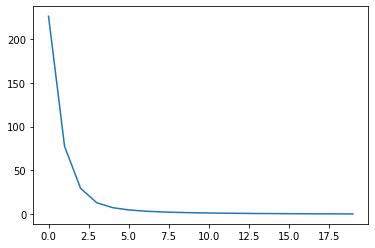

In [6]:
n_epoch=20
model_cbow, loss_box=cbow_train(n_epoch)
plt.plot(loss_box)

## CBOW 测试

In [7]:
def test_cbow(test_data, model):
    print('====Test CBOW===')
    correct_ct = 0
    for ctx, target in test_data:
        ctx_idxs = [w2i[w] for w in ctx]
        ctx_var = Variable(torch.LongTensor(ctx_idxs))

        model.zero_grad()
        model.eval()
        log_probs = model(ctx_var)
        _, predicted = torch.max(log_probs.data, 1)
        # print(predicted.data)
        predicted_word = i2w[predicted[0].item()]
        # print('predicted:', predicted_word)
        # print('label    :', target)
        if predicted_word == target:
            correct_ct += 1
            
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

In [8]:
test_cbow(cbow_train_data, model_cbow)
## 毕竟是个demo，只能用自己做预测了

====Test CBOW===
Accuracy: 100.0% (58/58)


## SKIPGRAM

In [9]:
class SKIPGRAM(nn.Module):
    def __init__(self,vocab_size,embd_size,hid_size,context_size):
        super(SKIPGRAM,self).__init__()
        self.emb=nn.Embedding(vocab_size,embd_size)
        self.layer=nn.Sequential(
            nn.Linear(embd_size,hid_size),
            nn.Tanh(),
            nn.Linear(hidden_size,vocab_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self,inputs):
        emb_out1=self.emb(inputs)
        log_prob=self.layer(emb_out1)
        return log_prob  

In [10]:
embd_size = 100
learning_rate = 1e-3
# CONTEXT_SIZE = 2 之前定义的
hidden_size=200
dim_embedding=100


def skip_train(n_epoch):
    loss_fn = nn.NLLLoss()
    model_skip=SKIPGRAM(len(vocab),embd_size,hidden_size, CONTEXT_SIZE)
    model_skip.train()
    print(model_skip)

    opt_skip=torch.optim.Adam(model_skip.parameters(),lr=learning_rate)
    loss_box=[]
    for epoch in range(n_epoch):
        total_loss = .0
        for context,target in skipgram_train_data:
            ctx_idx=[w2i[context] ]
            target=[w2i[word] for word in target]
            
            ctx_var= Variable(torch.LongTensor(ctx_idx))

            log_out=model_skip(ctx_var)

            opt_skip.zero_grad()

            loss = torch.sum(torch.stack([
                            loss_fn(log_out, torch.LongTensor([word]) ) for word in target
                        ]))
            loss.backward()
            opt_skip.step()
            
            total_loss += loss.float()
        print("epoch {} : loss is {:.4f}".format(epoch,total_loss))
        loss_box.append(total_loss)
        
    return model_skip, loss_box

## SKIPGRAM 训练

SKIPGRAM(
  (emb): Embedding(47, 100)
  (layer): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=47, bias=True)
    (3): LogSoftmax()
  )
)
epoch 0 : loss is 901.0943
epoch 1 : loss is 760.9941
epoch 2 : loss is 667.2169
epoch 3 : loss is 593.3518
epoch 4 : loss is 541.3200
epoch 5 : loss is 507.3879
epoch 6 : loss is 485.8603
epoch 7 : loss is 472.1047
epoch 8 : loss is 462.9831
epoch 9 : loss is 456.5994
epoch 10 : loss is 451.8888
epoch 11 : loss is 448.2389
epoch 12 : loss is 445.3215
epoch 13 : loss is 442.9338
epoch 14 : loss is 441.1221
epoch 15 : loss is 440.6208
epoch 16 : loss is 440.9155
epoch 17 : loss is 439.3954
epoch 18 : loss is 440.8800
epoch 19 : loss is 443.7508
epoch 20 : loss is 442.3715
epoch 21 : loss is 446.1616
epoch 22 : loss is 448.8828
epoch 23 : loss is 444.7736
epoch 24 : loss is 444.0458
epoch 25 : loss is 439.8763
epoch 26 : loss is 439.5896
epoch 27 : loss is 437.661

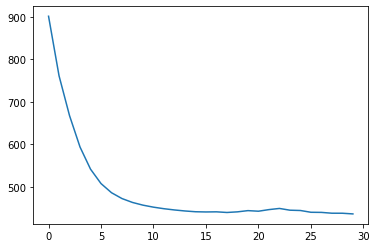

In [11]:
n_epoch=30
model_skip, loss_box=skip_train(n_epoch)
plt.plot(loss_box)

## SKIPGRAM 测试

In [12]:
def test_skipgram(test_data, model):
    print('====Test SkipGram===')
    correct_ct = 0
    for in_w, target in test_data:
        in_w_var = Variable(torch.LongTensor([w2i[in_w]]))
        out_w_var = [w2i[word] for word in target]

        model_skip.eval()
        model_skip.zero_grad()

        log_probs = model(in_w_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted = predicted[0]
        # print('predicted:', predicted)
        # print('label    :', out_w_var)
        if predicted in out_w_var:
            correct_ct += 1

    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

In [13]:
test_skipgram(skipgram_train_data, model_skip)

====Test SkipGram===
Accuracy: 87.9% (51/58)
